In [1]:
import time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, GRU
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers



#import seaborn as sns
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix, precision_recall_curve
#from sklearn.metrics import recall_score, classification_report, auc, roc_curve
#from sklearn.metrics import precision_recall_fscore_support, f1_score
#from sklearn.preprocessing import StandardScaler
from pylab import rcParams
tf.__version__

Using TensorFlow backend.


'1.8.0'

# Model Name

In [2]:
name = "ABS_Keras-LSTM254LSTM128D32D2-adam{}".format(int(time.time()))
#name_noTime = "ABS_Keras-LSTM128LSTM128D32D2-adam"

# Choose default months & paths, columns(features) and number of loans to load, train/test split

In [3]:
default_months = 6
nrows = 1000000
train_split = 0.90
model = keras
path = 'c:/users/ugy1/abs/'
rows_for_prediction = 1000
LABELS = ('Current', 'Not Current')

column_list = ['abs_loan.originationdate', 'abs_loan.originalloanamount','abs_loan.originalloanterm',
'abs_loan.originalinterestratepercentage','abs_loan.vehiclenewusedcode','abs_loan.vehiclevalueamount',
'abs_loan.obligorcreditscore','abs_loan.obligorincomeverificationlevelcode','abs_loan.obligoremploymentverificationcode',
'abs_loan.paymenttoincomepercentage','abs_loan.remainingtermtomaturitynumber',
'abs_loan.reportingperiodbeginningloanbalanceamount','abs_loan.nextreportingperiodpaymentamountdue',
'abs_loan.reportingperiodinterestratepercentage','abs_loan.nextinterestratepercentage',
'abs_loan.servicingfeepercentage','abs_loan.otherservicerfeeretainedbyservicer',
'abs_loan.otherassesseduncollectedservicerfeeamount','abs_loan.scheduledinterestamount', 
'abs_loan.scheduledprincipalamount','abs_loan.otherprincipaladjustmentamount',
'abs_loan.reportingperiodactualendbalanceamount','abs_loan.reportingperiodscheduledpaymentamount',
'abs_loan.totalactualamountpaid','abs_loan.actualinterestcollectedamount','abs_loan.actualprincipalcollectedamount',
'abs_loan.actualothercollectedamount','abs_loan.serviceradvancedamount', 'abs_loan.currentdelinquencystatus']

# GPU Options

In [4]:
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
# sess=tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

# Load data

In [5]:
df=pd.read_csv(path+'datasets/s3tab/abs_loan.csv', 
               usecols=column_list, 
               sep='\t',
               nrows=nrows,
               low_memory=False, 
              index_col='abs_loan.originationdate', 
               parse_dates=True
              )
print(df.shape)
df.dtypes

(1000000, 28)


abs_loan.originalloanamount                           float64
abs_loan.originalloanterm                               int64
abs_loan.originalinterestratepercentage               float64
abs_loan.vehiclenewusedcode                             int64
abs_loan.vehiclevalueamount                           float64
abs_loan.obligorcreditscore                           float64
abs_loan.obligorincomeverificationlevelcode             int64
abs_loan.obligoremploymentverificationcode              int64
abs_loan.paymenttoincomepercentage                    float64
abs_loan.remainingtermtomaturitynumber                  int64
abs_loan.reportingperiodbeginningloanbalanceamount    float64
abs_loan.nextreportingperiodpaymentamountdue          float64
abs_loan.reportingperiodinterestratepercentage        float64
abs_loan.nextinterestratepercentage                   float64
abs_loan.servicingfeepercentage                       float64
abs_loan.otherservicerfeeretainedbyservicer           float64
abs_loan

# Clean data

In [6]:
# change columns to lower case and remove prefix to enable pandas to work
column_list=[x.lower() for x in (column_list)]
df.columns=df.columns.str.replace('abs_loan.','')
# convert objects to numeric
#df=df.convert_objects(convert_numeric=True)

# Check for null

In [7]:
df.isnull().values.any()

True

# Loan Statistics

In [8]:
df.describe()

,originalloanamount,originalloanterm,originalinterestratepercentage,vehiclenewusedcode,vehiclevalueamount,obligorcreditscore,obligorincomeverificationlevelcode,obligoremploymentverificationcode,paymenttoincomepercentage,remainingtermtomaturitynumber,...,scheduledprincipalamount,otherprincipaladjustmentamount,reportingperiodactualendbalanceamount,reportingperiodscheduledpaymentamount,totalactualamountpaid,actualinterestcollectedamount,actualprincipalcollectedamount,actualothercollectedamount,serviceradvancedamount,currentdelinquencystatus
count,1000000.000000,1000000.000000,1000000.00000,1000000.000000,1.000000e+06,956434.000000,1000000.000000,1000000.000000,998058.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,585678.000000,1000000.000000
mean,26798.861306,64.584190,1.68655,1.501388,3.206637e+04,717.122269,2.051692,2.028226,2.845555,49.652653,...,363.807156,142.875143,19425.504057,466.067118,602.343593,90.008221,514.181761,2.435522,1.666000,2.599470
std,14203.851901,9.572844,2.45960,0.499998,5.337953e+04,106.919954,0.222212,0.263574,4.692949,18.154550,...,264.776911,1865.259409,12351.168692,265.653898,2080.998070,138.647971,2076.629077,23.596166,15.838474,15.691225
min,1624.630000,12.000000,0.00000,1.000000,0.000000e+00,0.000000,2.000000,1.000000,0.000000,0.000000,...,-38.760000,-72031.970000,0.000000,0.000000,-72031.970000,-1303.820000,-72031.970000,-69.510000,0.000000,-9.000000
25%,16930.812500,60.000000,0.13900,1.000000,1.823584e+04,639.000000,2.000000,2.000000,0.078245,39.000000,...,176.280000,0.000000,11198.557500,317.710000,250.000000,5.840000,81.887500,0.000000,0.000000,0.000000
50%,24021.030000,66.000000,0.90000,2.000000,2.709000e+04,730.000000,2.000000,2.000000,0.151346,52.000000,...,330.030000,0.000000,17672.600000,435.710000,419.400000,35.265000,323.940000,0.000000,0.000000,0.000000
75%,33227.800000,72.000000,2.90000,2.000000,4.196500e+04,806.000000,2.000000,2.000000,4.520000,65.000000,...,491.710000,0.000000,25642.965000,585.040000,600.000000,107.010000,514.290000,0.000000,0.000000,0.000000
max,189984.120000,75.000000,22.99000,2.000000,1.021234e+07,900.000000,5.000000,3.000000,96.950000,200.000000,...,4945.480000,137706.250000,177603.400000,4975.230000,140576.750000,3447.000000,140460.800000,3831.100000,1223.295300,442.000000


# Current Vs Non-Current

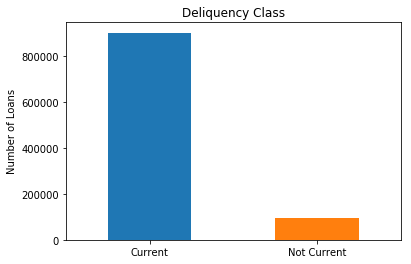

Number of loans Current : 903004     Number of loans Not Current : 96996


In [9]:
count_classes = pd.value_counts(df.currentdelinquencystatus>0, sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS)
plt.title('Deliquency Class')
plt.ylabel("Number of Loans")
plt.show()
print('Number of loans Current :', count_classes[0],'   ', 'Number of loans Not Current :', count_classes[1],)

In [10]:
pd.value_counts(df.currentdelinquencystatus)

 0      903002
 2        6204
 5        6076
 3        4898
 4        4692
 1        4108
 6        3836
 10       3771
 15       3702
 7        3663
 8        3191
 9        2944
 12       2461
 11       2270
 14       2216
 13       2216
 16       2075
 17       1999
 30       1923
 18       1704
 20       1701
 19       1612
 21       1385
 22       1203
 23       1128
 25       1123
 26       1089
 24       1003
 27        918
 29        880
         ...  
 298         4
 267         4
 268         4
 252         4
 355         3
 356         3
 349         3
 323         3
 328         3
 341         3
 339         3
 337         3
 313         3
 262         3
 342         3
 343         2
 321         2
 351         2
 350         2
 332         2
 348         2
 271         2
 442         1
 390         1
 391         1
 354         1
-9           1
 358         1
 353         1
-1           1
Name: currentdelinquencystatus, Length: 363, dtype: int64

# Label Creation

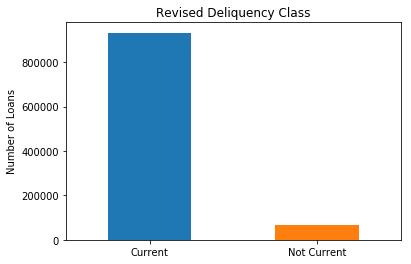

Number of loans Current : 932818     Number of loans Defaulted : 67182
New Vehicle Percent default:  6.7182


In [11]:
def map_label(*args):
    columns = [col for col in args]
    for column in columns:
        if column > default_months:
            return 1
        elif column <= default_months:
            return 0
        
df['label'] = list(map(map_label, df.currentdelinquencystatus ))


count_classes = pd.value_counts(df.label, sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS)
plt.title('Revised Deliquency Class')
plt.ylabel("Number of Loans")
plt.show()
print('Number of loans Current :', count_classes[0],'   ', 'Number of loans Defaulted :', count_classes[1],)
print('New Vehicle Percent default: ', (count_classes[1]/(count_classes[0]+count_classes[1]))*100 )

# Loan Balance Amount at the End of Reporting Period

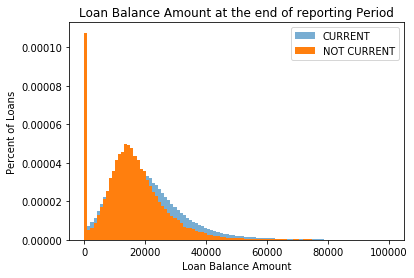

In [12]:
current_df = df[df.label==0]
not_current_df = df[df.label==1]
bins = np.linspace(0, 100000, 100)
plt.hist(current_df.reportingperiodactualendbalanceamount, bins, alpha=0.6, density=True, label='CURRENT')
plt.hist(not_current_df.reportingperiodactualendbalanceamount, bins, alpha=1, density=True, label='NOT CURRENT')
plt.legend(loc='upper right')
plt.title("Loan Balance Amount at the end of reporting Period")
plt.xlabel('Loan Balance Amount')
plt.ylabel('Percent of Loans')
plt.show()
#pd.value_counts(df.reportingperiodactualendbalanceamount[df.label==0])


# New Vehicle Default

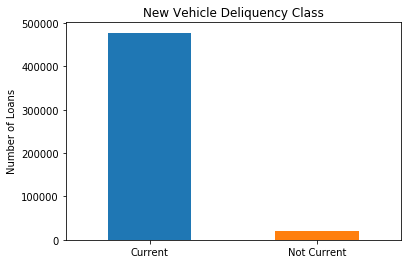

Number of loans Current : 477774     Number of loans Defaulted : 20838
New Vehicle Percent default:  4.17920146326


In [13]:
count_classes = pd.value_counts(df.label[df.vehiclenewusedcode==1], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS)
plt.title('New Vehicle Deliquency Class')
plt.ylabel("Number of Loans")
plt.show()
print('Number of loans Current :', count_classes[0],'   ', 'Number of loans Defaulted :', count_classes[1],)
print('New Vehicle Percent default: ', (count_classes[1]/(count_classes[0]+count_classes[1]))*100 )

# Used Vehicle default

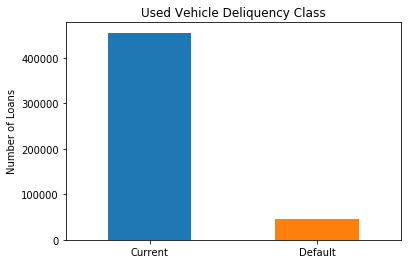

Number of loans Current : 455044     Number of loans Defaulted : 46344
Used Vehicle Percent default:  9.24314104047


In [14]:
LABELS = ('Current', 'Default')
count_classes = pd.value_counts(df.label[df.vehiclenewusedcode==2], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS)
plt.title('Used Vehicle Deliquency Class')
plt.ylabel("Number of Loans")
plt.show()
print('Number of loans Current :', count_classes[0],'   ', 'Number of loans Defaulted :', count_classes[1],)
print('Used Vehicle Percent default: ', (count_classes[1]/(count_classes[0]+count_classes[1]))*100 )

#  Clean up for Machine Learning

In [15]:
df.fillna(0, inplace=True)
df=df.replace([np.inf, -np.inf], np.nan)
df.dropna(inplace=True)
df.head()

,originalloanamount,originalloanterm,originalinterestratepercentage,vehiclenewusedcode,vehiclevalueamount,obligorcreditscore,obligorincomeverificationlevelcode,obligoremploymentverificationcode,paymenttoincomepercentage,remainingtermtomaturitynumber,...,otherprincipaladjustmentamount,reportingperiodactualendbalanceamount,reportingperiodscheduledpaymentamount,totalactualamountpaid,actualinterestcollectedamount,actualprincipalcollectedamount,actualothercollectedamount,serviceradvancedamount,currentdelinquencystatus,label
abs_loan.originationdate,,,,,,,,,,,,,,,,,,,,,
2012-12-31,25124.50,72,3.29,1,44395.0,812.0,2,2,2.66,13,...,0.0,4479.55,385.00,385.00,13.30,371.70,0.0,0.0,0,0
2012-12-31,43257.34,72,3.29,1,50595.0,817.0,2,2,3.99,14,...,0.0,8328.13,663.71,663.71,24.58,639.13,0.0,0.0,0,0
2012-12-31,56917.54,72,3.29,1,62695.0,818.0,2,2,6.97,14,...,0.0,11979.91,873.39,873.39,35.14,838.25,0.0,0.0,0,0
2012-12-31,42003.57,72,3.29,1,46995.0,791.0,2,2,2.96,13,...,0.0,8182.63,643.71,643.71,24.12,619.59,0.0,0.0,0,0
2012-12-31,77217.85,72,3.29,1,76145.0,712.0,2,2,10.37,14,...,0.0,16336.95,1184.89,1160.89,47.92,1136.97,24.0,0.0,0,0


# Preparing data for Machine Learning

In [16]:
# prepare label
Y=df.label.values
Y.shape

(1000000,)

In [17]:
# reshape labels for machine learning
Y=Y.reshape(Y.shape[0],1)
Y.shape

(1000000, 1)

In [18]:
# prepare input data
input=df.values
input.shape

(1000000, 29)

In [19]:
# calculate train/test split
len_train = int(len(input)*train_split)
print(len_train)

900000


In [20]:
# apply train/test split to labels
y_train = Y[0:len_train]
y_test = Y[len_train:]

In [21]:
#drop unneeded columns for creating input data
df.drop(['currentdelinquencystatus','label'], axis=1, inplace=True)

In [22]:
#reshape input data for machine learning
input=input.reshape(input.shape[0], input.shape[1], 1)
input.shape

(1000000, 29, 1)

In [23]:
# apply train/test split to input data
x_train = input[0:len_train]
x_test = input[len_train:]

# Normalize input data

In [24]:
x_train_keras_scaled = keras.utils.normalize(x_train, axis=-1, order=2)
x_test_keras_scaled = keras.utils.normalize(x_test, axis=-1, order=2)
x_train_keras_scaled.shape

(900000, 29, 1)

# Model Architecture

In [25]:
model = keras.Sequential()
model.add(keras.layers.LSTM(254, activation='relu', input_shape=(x_train_keras_scaled.shape[1:]), return_sequences=True))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.LSTM(128, activation='relu'))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(2, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-6)


# Model Configuration

In [26]:
#save the best model
# keras.callbacks.Callback()
# checkPoint = ModelCheckpoint(filepath = path+'model/'+name+'.h5',
#                             save_best_only = True,
#                             verbose=0)
# tensorboard = TensorBoard(log_dir=path+'logs/{}'.format(name),
#                          histogram_freq=0,
#                          batch_size=32,
#                          write_graph=True,
#                          write_images=False)
# history = keras.callbacks.History()

# Train the Model

In [27]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.fit(x_train, y_train, epochs=1, validation_data=(x_test_keras_scaled, y_test), 
         # callbacks = [
   # baseLogger,
    #history,
    #tensorboard,
    #learningRateScheduler,
    #reduceLROnPlateau
#], 
          shuffle=False
)


Train on 900000 samples, validate on 100000 samples
Epoch 1/1
 28064/900000 [..............................] - ETA: 56:23 - loss: 0.4449 - acc: 0.9722

KeyboardInterrupt: 

# Save the Model

In [ ]:
model.save(path+'model/'+name+'.h5')

In [ ]:
test_loss, test_acc = model.evaluate(x_test_keras_scaled, y_test)
print('Test Loss : ',test_loss,' ','Test Accuracy : ', test_acc)

# Load Saved Model

In [ ]:
#saved_model = load_model(path+'model/ABS_Keras-LSTM254LSTM128D32D2-adam1540234865.h5')

In [ ]:
#test_loss, test_acc = saved_model.evaluate(x_test_keras_scaled, y_test)
#print('Test Loss : ',test_loss,' ','Test Accuracy : ', test_acc)